In [2]:
import sys
sys.path.insert(0, '../tools')

%load_ext prov_magics
import provn
import prov_dictionary

In [3]:
from pprint import pprint
import annotations as prov

3


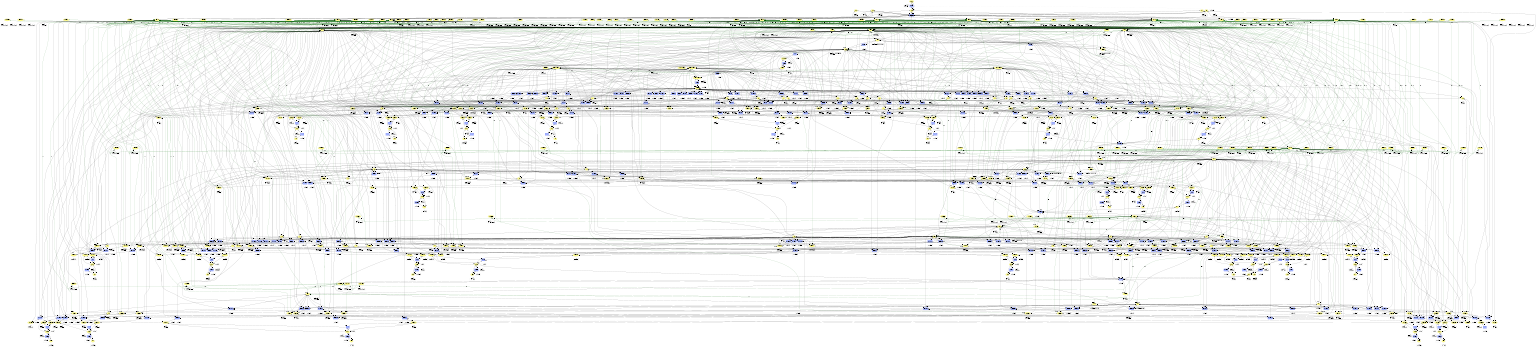

[('used', 695),
 ('entity', 396),
 ('wasDerivedFrom', 304),
 ('wasGeneratedBy', 295),
 ('activity', 272),
 ('derivedByInsertionFrom', 105)]


In [5]:
import importlib
import annotations as prov
importlib.reload(prov)
prov.reset_prov()

# Line 1
m = 10000 # max value

with prov.desc("L1 - assign"):
    e_n10000 = prov.entity("n", "10000", "literal", num=10000)

    e_m = prov.entity("m", "10000", "name")
    prov.activity("assign", [(e_m, e_n10000)])

# Line 2
result = dist = [
    [0, 1, 4],
    [m, 0, 2],
    [2, m, 0],
]

with prov.desc("L2 - list definition / assign"):
    
    with prov.desc("list definition"):
        e_n0 = prov.entity("n", "0", "literal", num=0)
        e_n1 = prov.entity("n", "1", "literal", num=1)
        e_n2 = prov.entity("n", "2", "literal", num=2)
        e_n4 = prov.entity("n", "4", "literal", num=4)

        prov_dist = [
            [e_n0, e_n1, e_n4],
            [e_m, e_n0, e_n2],
            [e_n2, e_m, e_n0],
        ]
        
        e_list, rows = prov.define_array("list", dist)
        
        derived = []
        generated = [e_list]
        for i, row in enumerate(rows):
            e_erow = prov.entity("e" + row[0], "[]", "EmptyDictionary")
            prov.derivedByInsertionFrom(row[0], e_erow, row[1])
            generated.append(row[0])
            for j, ent in enumerate(row[1]):
                derived.append((ent, prov_dist[i][j]))
        row_ents = [row[0] for row in rows]
        
        e_elist = prov.entity("elist_", "[]", "EmptyDictionary")
        prov.derivedByInsertionFrom(e_list, e_elist, row_ents)

        prov.activity("definelist", derived, generated=generated)
        
    with prov.desc("assign"):
        e_edist = prov.entity("edist_", "[]", "EmptyDictionary")
        e_dist = prov.entity("dist_", repr(dist), "Dictionary")
        prov.derivedByInsertionFrom(e_dist, e_edist, row_ents)

        e_eresult = prov.entity("eresult_", "[]", "EmptyDictionary")
        e_result = prov.entity("result_", repr(result), "Dictionary")
        prov.derivedByInsertionFrom(e_result, e_eresult, row_ents)

        prov.activity("assign", [(e_dist, e_list)])
        prov.activity("assign", [(e_result, e_list)])

# Line 7
nodes = len(dist)

with prov.desc("L7 - func call / assign"):
    e_ret = prov.entity("len_dist", repr(nodes), "eval")
    prov.activity("len", [], [e_dist], [e_ret])
    
    e_nodes = prov.entity("nodes", repr(nodes), "name")
    prov.activity("assign", [(e_nodes, e_ret)])

# Line 8
indexes = range(nodes)

with prov.desc("L8 - func call / list assign"):
    e_ret, el_ents = prov.define_array("range_nodes", list(indexes))
    
    e_eret = prov.entity("erange_nodes", "[]", "EmptyDictionary")
    prov.derivedByInsertionFrom(e_ret, e_eret, el_ents)
    prov.activity("range", [], [e_nodes], [e_ret])
    
    e_eindexes = prov.entity("eindexes", "[]", "EmptyDictionary")
    e_indexes = prov.entity("indexes", repr(list(indexes)), "range")
    prov.derivedByInsertionFrom(e_indexes, e_eindexes, el_ents)

    prov.activity("assign", [(e_indexes, e_ret)])

# Line 9
for k in indexes:
    with prov.desc("L9 - loop access"):
        e_k = prov.entity("k", k, "name")
        prov.activity("access", [(e_k, prov.DICTS[e_indexes][repr(k)])], used=[e_indexes])
    
    # Line 10
    for i in indexes:
        with prov.desc("L10 - loop access"):
            e_i = prov.entity("i", k, "name")
            prov.activity("access", [(e_i, prov.DICTS[e_indexes][repr(i)])], used=[e_indexes])
        
        # Line 11
        for j in indexes:
            with prov.desc("L11 - loop access"):
                e_j = prov.entity("j", k, "name")
                prov.activity("access", [(e_j, prov.DICTS[e_indexes][repr(j)])], used=[e_indexes])
            
            # Line 12
            ikj = dist[i][k] + dist[k][j]
            
            with prov.desc("L12 - access / access / access / access / operation / assign"):
                with prov.desc("dist[i]"):
                    e_edist_ai = prov.entity("edist_ai", "[]", "EmptyDictionary")
                    e_dist_ai = prov.entity("dist_ai", repr(dist[i]), "Dictionary")
                    item = prov.DICTS[e_dist][str(i)]
                    elements = [x[1] for x in sorted(list(prov.DICTS[item].items()))]
                    prov.derivedByInsertionFrom(e_dist_ai, e_edist_ai, elements)
                    prov.activity("access", [(e_dist_ai, item)], used=[e_dist, e_i])

                with prov.desc("dist[i][k]"):
                    e_disti_ak = prov.entity("disti_ak", repr(dist[i][k]), "access")
                    item = prov.DICTS[e_dist_ai][str(k)]
                    prov.activity("access", [(e_disti_ak, item)], used=[e_dist_ai, e_k])
                    
                with prov.desc("dist[k]"):
                    e_edist_ak = prov.entity("edist_ak", "[]", "EmptyDictionary")
                    e_dist_ak = prov.entity("dist_ak", repr(dist[k]), "Dictionary")
                    item = prov.DICTS[e_dist][str(k)]
                    elements = [x[1] for x in sorted(list(prov.DICTS[item].items()))]
                    prov.derivedByInsertionFrom(e_dist_ak, e_edist_ak, elements)
                    prov.activity("access", [(e_dist_ak, item)], used=[e_dist, e_k])

                with prov.desc("dist[k][j]"): 
                    e_distk_aj = prov.entity("distk_aj", repr(dist[k][j]), "access")
                    item = prov.DICTS[e_dist_ak][str(j)]
                    prov.activity("access", [(e_distk_aj, item)], used=[e_dist_ak, e_j])
                
                e_sum = prov.entity("sum", repr(ikj), "sum")
                prov.activity("add", [(e_sum, e_disti_ak, e_distk_aj)])
                
                e_ikj = prov.entity("ikj", repr(ikj), "name")
                prov.activity("assign", [(e_ikj, e_sum)])
                
            
            # Line 13
            with prov.desc("L13 - access / access"):
                with prov.desc("dist[i]"):
                    e_edist_ai = prov.entity("edist_ai", "[]", "EmptyDictionary")
                    e_dist_ai = prov.entity("dist_ai", repr(dist[i]), "Dictionary")
                    item = prov.DICTS[e_dist][str(i)]
                    elements = [x[1] for x in sorted(list(prov.DICTS[item].items()))]
                    prov.derivedByInsertionFrom(e_dist_ai, e_edist_ai, elements)
                    prov.activity("access", [(e_dist_ai, item)], used=[e_dist, e_i])
                
                with prov.desc("dist[i][j]"):
                    e_disti_aj = prov.entity("disti_aj", repr(dist[i][j]), "access")
                    item = prov.DICTS[e_dist_ai][str(j)]
                    prov.activity("access", [(e_disti_aj, item)], used=[e_dist_ai, e_j])
            
            if dist[i][j] > ikj:
                
                # Line 14
                dist[i][j] = ikj
                
                with prov.desc("L14 - part assign with propagation"):
                    used = [e_disti_aj] # from if
                    generated = []
                    
                    with prov.desc("access dist[i]"):
                        e_edist_ai = prov.entity("edist_ai", "[]", "EmptyDictionary")
                        e_dist_ai = prov.entity("dist_ai", repr(dist[i]), "Dictionary")
                        item = prov.DICTS[e_dist][str(i)]
                        elements = [x[1] for x in sorted(list(prov.DICTS[item].items()))]
                        prov.derivedByInsertionFrom(e_dist_ai, e_edist_ai, elements)
                        prov.activity("access", [(e_dist_ai, item)], used=[e_dist, e_i])
                    
                    
                    with prov.desc("update dist[i] - local"):
                        e_disti_aj = prov.entity("disti_aj", repr(ikj), "access")
                    
                        new_e_disti = prov.entity("dist_ai", repr(dist[i]), "Dictionary")
                        prov.derivedByInsertionFrom(new_e_disti, e_dist_ai, {j: e_disti_aj})
                        used.append(e_dist_ai)
                        generated.append(new_e_disti)
                        
                    with prov.desc("update dist[i] - global"):
                        e_item = prov.DICTS[e_dist][str(i)]
                        new_e_item = prov.entity("list{}_".format(i), repr(dist[i]), "Dictionary")
                        prov.derivedByInsertionFrom(new_e_item, e_item, {j: e_disti_aj})
                        used.append(e_item)
                        generated.append(new_e_item)
                        
                    with prov.desc("update dist"):
                        new_e_dist = prov.entity("dist", repr(dist), "Dictionary")
                        prov.derivedByInsertionFrom(new_e_dist, e_dist, {i: new_e_item})
                        used.append(e_dist)
                        generated.append(new_e_dist)
                        
                    with prov.desc("update result"):
                        new_e_result = prov.entity("result", repr(dist), "Dictionary")
                        prov.derivedByInsertionFrom(new_e_result, e_result, {i: new_e_item})
                        used.append(e_result)
                        generated.append(new_e_result)
                    
                    prov.activity("assign", [(e_disti_aj, e_ikj)], used=used, generated=generated)
                    
                    e_dist = new_e_dist
                    e_result = new_e_result
                    
                    
                    
                

# Line 17
print(result[0][2])

with prov.desc("L17 - access / access / call"):
    e_eresult_a0 = prov.entity("eresult_a0", "[]", "EmptyDictionary")
    e_result_a0 = prov.entity("result_a0", repr(result[0]), "Dictionary")
    item = prov.DICTS[e_result]["0"]
    elements = [x[1] for x in sorted(list(prov.DICTS[item].items()))]
    prov.derivedByInsertionFrom(e_result_a0, e_eresult_a0, elements)

    prov.activity("access", [(e_result_a0, item)], used=[e_result, e_n0])
    
    e_result_a02 = prov.entity("result_a02", repr(result[0][2]), "number")
    item = prov.DICTS[e_result_a0]["2"]
    prov.activity("access", [(e_result_a02, item)], used=[e_result_a0, e_n2])
    
    prov.activity("print", [], [e_result_a02])

pprint(prov.stats("../prov_dictionary/floydwarshall", True))